TokaMaker Meshing Example: Building a mesh for DIII-D {#doc_tMaker_DIIID_ex1}
==========
In this example we show how to generate a mesh for the DIII-D device using TokaMaker's built in mesh generation.

**Note:** Running this example requires the [triangle](https://pypi.org/project/triangle/) and [h5py](https://www.h5py.org/) python packages. Both of which are installable using `pip` or other standard methods.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain, save_gs_mesh

# Build mesh

## Set mesh resolution for each region
First we define some target sizes to set the resolution in out grid. These variables will be used later and represent the target edge size within a given region, where units are in meters. In this case we are using a fairly coarse resolution of 4 cm in the plasma region and 10 cm in the vacuum region.

**Note:** When setting up a new machine these values will need to scale with the overall size of the device/domain. Additionally, one should perform a convergence study, by increasing resolution (decreasing target size) by at least a factor of two in all regions to ensure the results are not sensitive to your choice of grid size.

In [3]:
plasma_dx = 0.04
coil_dx = 0.03
vv_dx = 0.04
vac_dx = 0.10

## Load geometry information
The geometry information (eg. bounding curves for vacuum vessels) are now loaded from a JSON file. For simple geometries, testing, or generative usage this can be created directly in the code. However, it is often helpful to separate this information into a fixed datafile as here. This JSON file contains the following:
 - `limiter`: A contour of R,Z points defining the limiter (PFC) surface 
 - `vv`: Multiple contours of R,Z points defining the vacuum vessel as a set of poloidal segments
 - `coils`: A dictionary of values defining the E and F coils in the poloidal cross-section

In [4]:
with open('DIIID_geom.json','r') as fid:
    DIIID_geom = json.load(fid)

## Define regions and attributes
We now create and define the various logical mesh regions. In the DIII-D case we have 5 region groups:
 - `air`: The region outside the vacuum vessel
 - `plasma`: The region inside the limiter where the plasma will exist
 - `vacuum`: The region between the vacuum vessel and the limiter
 - `vv1,...`: The vacuum vessel, which is broken into multiple poloidal segments
 - `PF1,...`: Each of the 20 coil sets in DIII-D (2 E coils, 18 F coils)

For DIII-D all F coils are treated independently. For the E coils, which are each composed of many distributed windings, are grouped into single coil sets using the `coil_set` and `nTurns` arguments to \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.define_region "define_region()".

**Note:** By default, X-points are only searched for in the plasma region. The argument `allow_xpoints` to \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.define_region "define_region()" is used to allow inactive x-points in a specific region, the `vacuum` in this case.

For each region you can provide a target size and one of four region types:
 - `plasma`: The region where the plasma can exist and the classic Grad-Shafranov equation with $F*F'$ and $P'$ are allowed. **There can only be one region of this type**
 - `vacuum`: A region where no current can flow and $\nabla^* \psi = 0$ is solved
 - `boundary`: A special case of the `vacuum` region, which forms the outer boundary of the computational domain. **A region of this type is required if more than one region is specified**
 - `conductor`: A region where toroidal current can flow passively (no externally applied voltage). For this type of region the resistivity should be specified with the argument `eta` in units of $\omega \mathrm{-m}$.
 - `coil`: A region where toroidal current can flow with specified amplitude through \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_currents "set_coil_currents()" or via shape optimization \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_reg "set_coil_reg()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_isoflux "set_isoflux()"

In [5]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')                     # Define the bounding region
gs_mesh.define_region('plasma',plasma_dx,'plasma')                 # Define the plasma region and resolution
gs_mesh.define_region('vacuum',vv_dx,'vacuum',allow_xpoints=True)  # Define the vacuum inside the VV
# Define regions for VV
for i, vv_segment in enumerate(DIIID_geom["vv"]):
    gs_mesh.define_region('vv{0}'.format(i),vv_dx,'conductor',eta=vv_segment[1])
# Define each of the PF coils
for key, coil in DIIID_geom["coils"].items():
    if key.startswith('ECOIL'):
        for i, subcoil in enumerate(coil):
            gs_mesh.define_region('{0}_{1}'.format(key,i),coil_dx,'coil',coil_set=key,nTurns=subcoil["nturns"])
    else:
        gs_mesh.define_region(key,coil_dx,'coil',nTurns=coil["nturns"])

## Define geometry for region boundaries
Once the region types and properties are defined we now define the geometry of the mesh using shapes and references to the defined regions.
 1. We add the limiter contour as a "polygon", referencing `plasma` as the region enclosed by the contour and `vacuum` as the region outside the contour.
 2. We mark the location of the `vacuum` region using a point that lies inside that region. This is useful when the topology enclosing the region on one or more sides is formed by many regions, the vacuum vessel in this case.
 3. We add each of the segments that compose the vacuum vessel
 4. We add each of the E and F coils, which are defined as polygons to enable tilted coils. We also reference `air` as the region outside each coil.

In [6]:
# Define geometry
gs_mesh.add_polygon(DIIID_geom['limiter'],'plasma',parent_name='vacuum')  # Define the shape of the limiter
gs_mesh.add_enclosed([1.75,1.25],'vacuum')
# Define regions for VV
for i, vv_segment in enumerate(DIIID_geom["vv"]):
    gs_mesh.add_polygon(vv_segment[0],'vv{0}'.format(i),parent_name='air')
# Define each of the PF coils
for key, coil in DIIID_geom["coils"].items():
    if key.startswith('ECOIL'):
        for i, subcoil in enumerate(coil):
            gs_mesh.add_polygon(subcoil["pts"],'{0}_{1}'.format(key,i),parent_name='air')
    else:
        gs_mesh.add_polygon(coil["pts"],key,parent_name='air')

## Plot topology
After defining the logical and physical topology we can now plot the curves within the definitions to double check everything is in the right place.

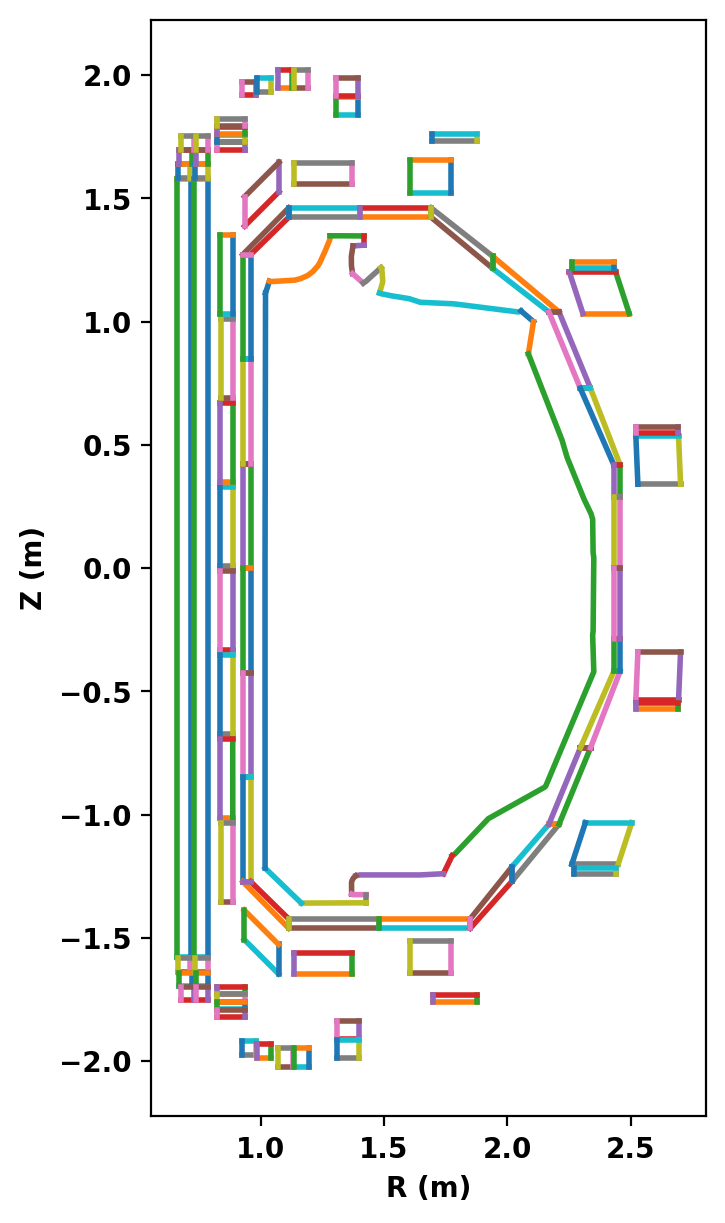

In [7]:
fig, ax = plt.subplots(1,1,figsize=(4,6),constrained_layout=True)
gs_mesh.plot_topology(fig,ax)

## Create mesh
Now we generate the actual mesh using the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.build_mesh "build_mesh()" method. Additionally, if `coil` and/or `conductor` regions are defined the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.get_coils "get_coils()" and \ref OpenFUSIONToolkit.TokaMaker.gs_Domain.get_conductors "get_conductors()" methods should also be called to get descriptive dictionaries for later use in TokaMaker. This step may take a few moments as [triangle](https://www.cs.cmu.edu/~quake/triangle.html) generates the mesh.

Note that, as is common with unstructured meshes, the mesh is stored a list of points `mesh_pts` of size (np,2), a list of cells formed from three points each `mesh_lc` of size (nc,3), and an array providing a region id number for each cell `mesh_reg` of size (nc,), which is mapped to the names above using the `coil_dict` and `cond_dict` dictionaries.

In [8]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 1756
  # of unique segments  = 329
Generating mesh:
  # of points  = 8912
  # of cells   = 17662
  # of regions = 85


## Plot resulting regions and grid
We now plot the mesh by region to inspect proper generation.

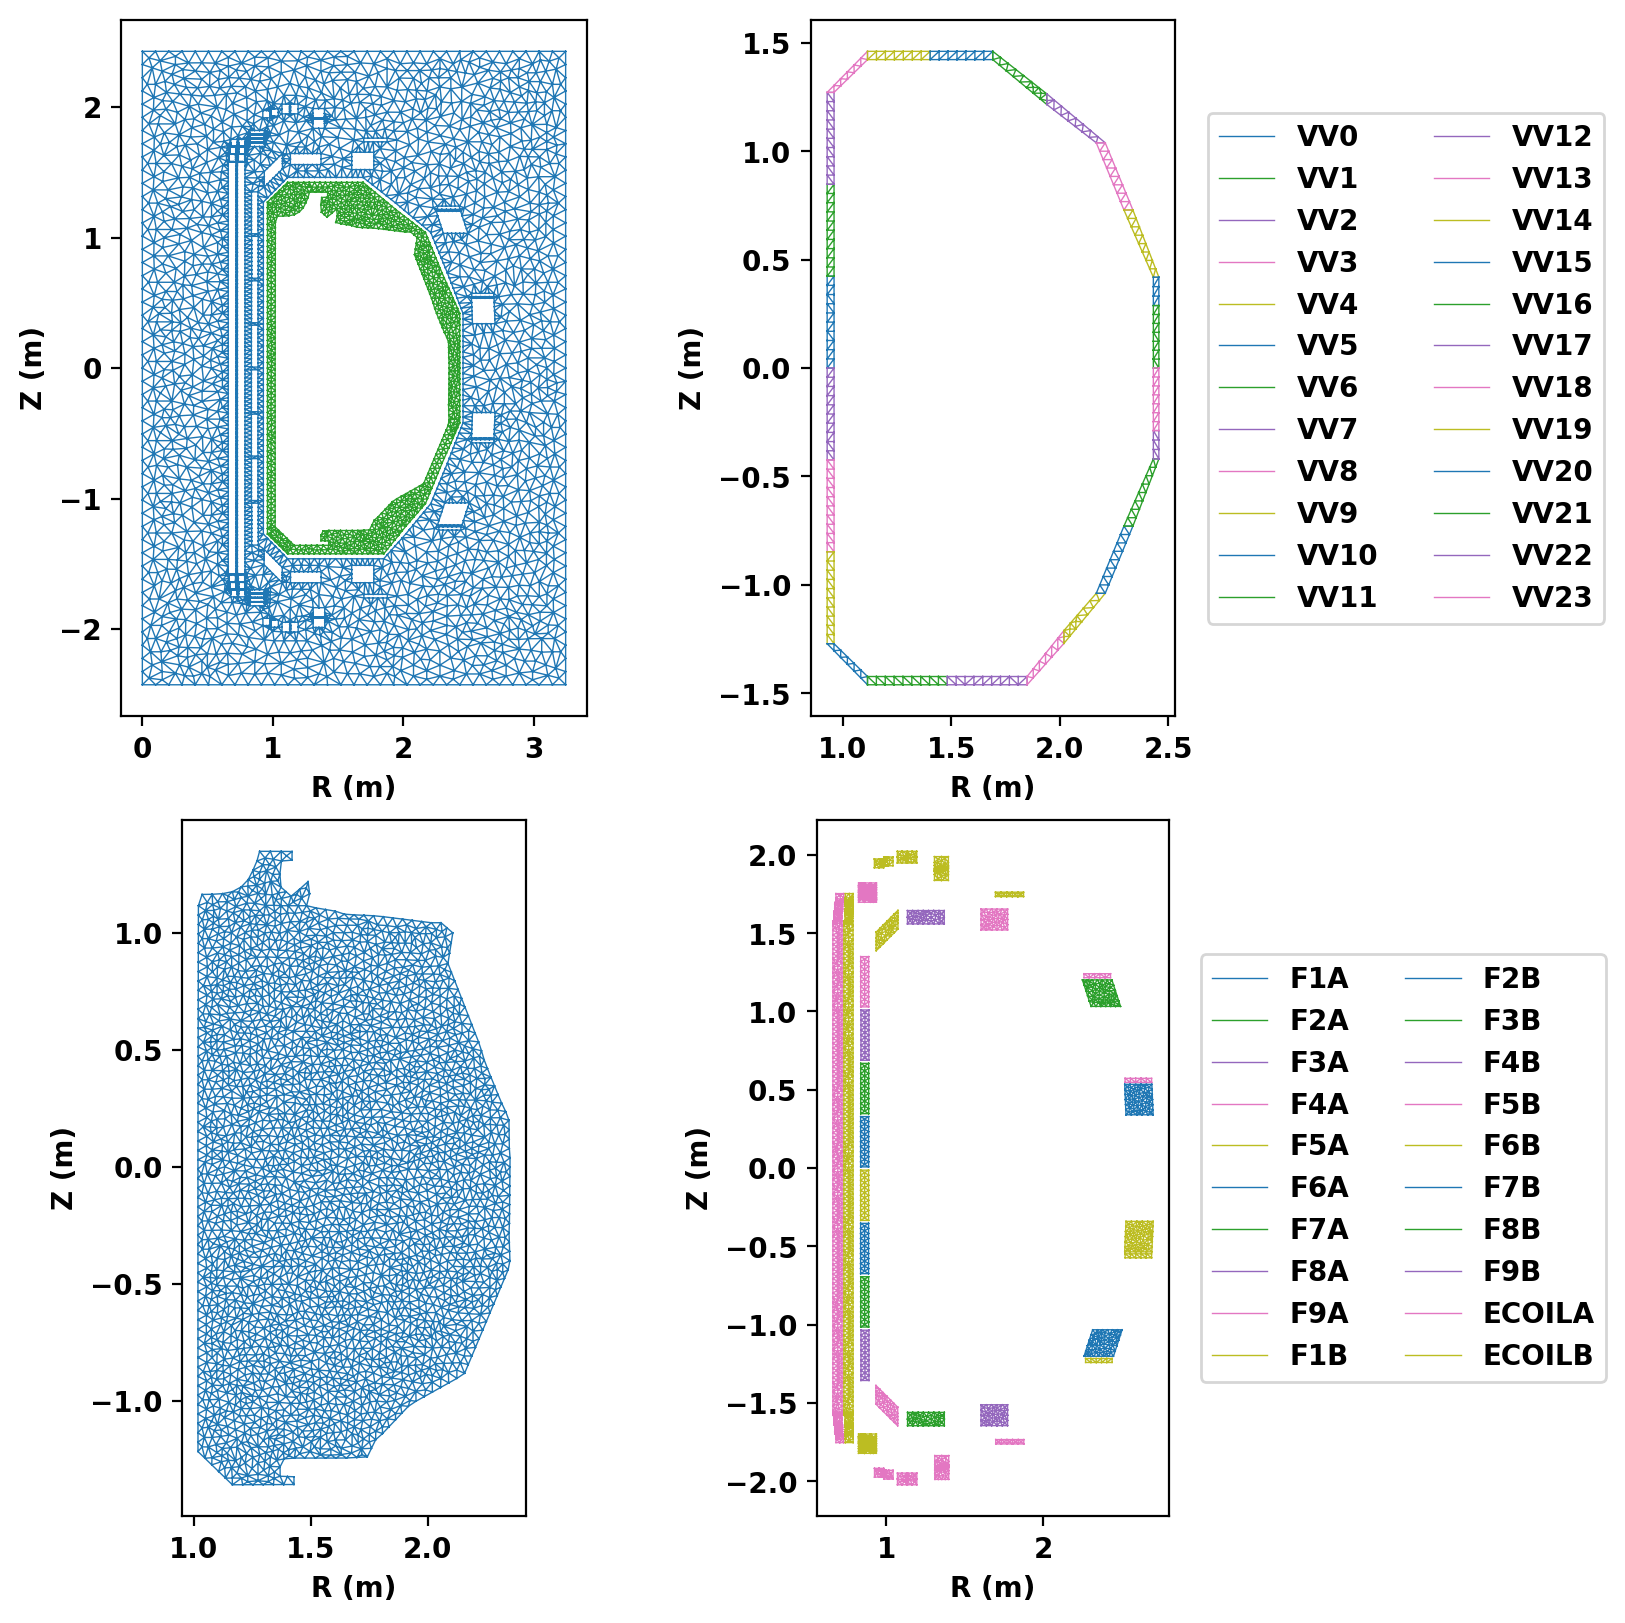

In [9]:
fig, ax = plt.subplots(2,2,figsize=(8,8),constrained_layout=True)
gs_mesh.plot_mesh(fig,ax)

## Save mesh for later use
As generation of the mesh often takes comparable, or longer, time compare to runs in TokaMaker it is useful to separate generation of the mesh into a different script as demonstrated here. The method \ref OpenFUSIONToolkit.TokaMaker.save_gs_mesh "save_gs_mesh()" can be used to save the resulting information for later use. This is done using and an [HDF5](https://www.hdfgroup.org/solutions/hdf5/) file through the [h5py](https://www.h5py.org/) library.

In [10]:
save_gs_mesh(mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict,'DIIID_mesh.h5')